<h2>Deep Learning Project - Herbarium</h2>
IA - GroupeB - Julien Delages | Loïc Esnault | Fedi Lahmar | Natan Le Bourdonnec | Dorian Roux


---

In [1]:
import os
import zipfile
from pathlib import Path
import re
import cv2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import PIL
from sklearn.metrics import confusion_matrix
import seaborn as sns


---

#### Import the "Dataset" Herbarium Images 

In [2]:
relativeProjectPath = Path.cwd()
dataPath = relativeProjectPath / 'Data'
if not os.path.exists(dataPath): # Verify whether the Data Folder exists or Create it
    Path(dataPath).mkdir(parents=True, exist_ok=True)  
    print(f'Data Path Folder created!')

Data Path Folder created!


In [3]:
# Python command that download the zippedFile of the Initial Data Images and Save it within the current Folder
%pip install wget
!python -m wget "https://docs.google.com/uc?export=download&confirm=$https://docs.google.com/uc?export=download&id=1NKaDghYPk3NEdQ4ZBVqXjSs1hNacNW6b&id=1NKaDghYPk3NEdQ4ZBVqXjSs1hNacNW6b" -o Dataset.zip


Saved under Dataset.zip


In [4]:
# Unzip the compressed Data Images Files and saved it within the Data Folder then remove the compressed file 
with zipfile.ZipFile(('Dataset.zip'), 'r') as zip_ref:
    zip_ref.extractall(dataPath)
Path('Dataset.zip').unlink()

---

#### Feature Engineering 

##### Verify that the Initial **Datasets** of Images based on the Herbarium exists

In [5]:
# Function that verify a Path and its content
def verifyFolderPathContent(initPath, labelPath='',):
    if not (os.path.exists(initPath)):  # Verify whether the current path exists or not 
        return print(f'{labelPath} Path -> Not Validated (Path does not Exists) \nVeriy the path or Reexecute the file: "InitializationDataHerbarium.ipynb"')
    if not os.listdir(initPath): # Verify whether the current path has empty content or not 
        return print(f'{labelPath} Path -> Not Validated (Path Exists BUT Path Content is Empty) \nVeriy the path or Reexecute the file: "InitializationDataHerbarium.ipynb"')
    return print(f'{labelPath} Path -> Validated (Path Exists AND Path Content is not Empty)')

In [6]:
initDatasetPath = dataPath / 'Dataset'
verifyFolderPathContent(initDatasetPath, 'Dataset')

Dataset Path -> Validated (Path Exists AND Path Content is not Empty)



##### Transform the IMAGES from both the **Train** and **Test** Initial Dataset

In [7]:
# Function that return the probable background color of the Image 
def getBackgroundBGR(Image):
    
    im = PIL.Image.fromarray(Image)
    background_color = im.getcolors(im.size[0]*im.size[1])

    colorsBGR = []
    for occurence, color in sorted(background_color, reverse=True)[:20]:
        colorsBGR.append(color)
                            
    blue_value = int(np.median(list(map(lambda x: x[0], colorsBGR))))
    green_value = int(np.median(list(map(lambda x: x[1], colorsBGR))))
    red_value = int(np.median(list(map(lambda x: x[2], colorsBGR))))
    return  (blue_value, green_value, red_value)

In [8]:
def manageImageRatioSize(Image, imageSize=512, imageInterpolation=cv2.INTER_AREA, imageBorderType=cv2.BORDER_CONSTANT):

    # Apply the Padding to the Image and Resize It
    ratioHeightWidth = Image.shape[0]/Image.shape[1]
    if ratioHeightWidth > 1: #Verify whether the padding should be apply (>1 is Height | <1 is Width)
        nbrPixels = int((Image.shape[1]*(ratioHeightWidth - 1))/2)
        nbrPixelsTop, nbrPixelsBottom = int(nbrPixels * 0.75), int(nbrPixels * 1.25)
        nbrPixelsBottom = nbrPixelsBottom if (nbrPixelsTop+nbrPixelsBottom == Image.shape[1]) else nbrPixelsBottom+1
        return cv2.resize(Image[nbrPixelsTop:-nbrPixelsBottom,:], (imageSize, imageSize), interpolation=imageInterpolation)
    
    nbrPixels = int((Image.shape[0]*(1-ratioHeightWidth))/2)
    nbrPixelsTop, nbrPixelsBottom = int(nbrPixels * 1), int(nbrPixels * 1)
    nbrPixelsBottom = nbrPixelsBottom if (nbrPixelsTop+nbrPixelsBottom == Image.shape[0]) else nbrPixelsBottom+1
    print(nbrPixels, nbrPixelsTop, nbrPixelsBottom)
    return cv2.resize(Image[:, nbrPixelsTop:-nbrPixelsBottom-1], (imageSize, imageSize), interpolation=imageInterpolation)

In [9]:
def makeImageTransformation(imagePath, prevFolderName='Dataset', uptFolderName='Transformed_Dataset', imageSize=512):
    
    # Step ~1: Read the Image
    Image = cv2.imread(imagePath)
        
    # Step ~2: Convert to Grayscale and Apply a GaussianBlur
    grayImage = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
    gaussianImage = cv2.GaussianBlur(grayImage, (51, 51), 0)
    
    # Step ~3: Apply a Binary and Otsu Threshold 
    _, threshImage = cv2.threshold(gaussianImage, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Step ~4: Apply a Binary and Otsu Threshold 
    colorizedImage = cv2.bitwise_or(Image, Image, mask=cv2.bitwise_not(threshImage))
    
    # Step ~5: Apply the Image Resize and Padding
    CroppedResizedImage = manageImageRatioSize(colorizedImage, imageSize)
    
    # Step ~5: Apply a Smooth modification of the Background Color
    backgroundColor = getBackgroundBGR(Image)
    preprocessedImage = np.where(CroppedResizedImage==[0, 0, 0], backgroundColor, CroppedResizedImage)

    # Step ~6: Save the Transformed Image following a similar Path (except for the main directory name)
    newImagePath = imagePath.__str__().replace(prevFolderName, uptFolderName)
    Path(newImagePath).parent.mkdir(parents=True, exist_ok=True)  # Verify whether the Folder exists and Create it
    cv2.imwrite(newImagePath, preprocessedImage)

In [10]:
transformFolder = 'Transformed_Dataset'
imageSize = 512

# Loop through each FILE and apply an IMAGE transformation
for dir_, _, files in os.walk(initDatasetPath):
    for file_name in files:
      imagePath = (initDatasetPath / dir_ / file_name).__str__()
      makeImageTransformation(imagePath, prevFolderName=initDatasetPath.name, uptFolderName=transformFolder, imageSize=imageSize)

##### Verify that Transformed **Train** and **Test** Datasets Images based on the Herbarium exists

In [11]:
modifDatasetPath = dataPath / 'Transformed_Dataset'
trainPath = modifDatasetPath / 'Train'
testPath = modifDatasetPath / 'Test'

verifyFolderPathContent(trainPath, 'Train')
verifyFolderPathContent(testPath, 'Test')

Train Path -> Validated (Path Exists AND Path Content is not Empty)
Test Path -> Validated (Path Exists AND Path Content is not Empty)


##### Visualize a Sample from the Transformed **Train** Dataset

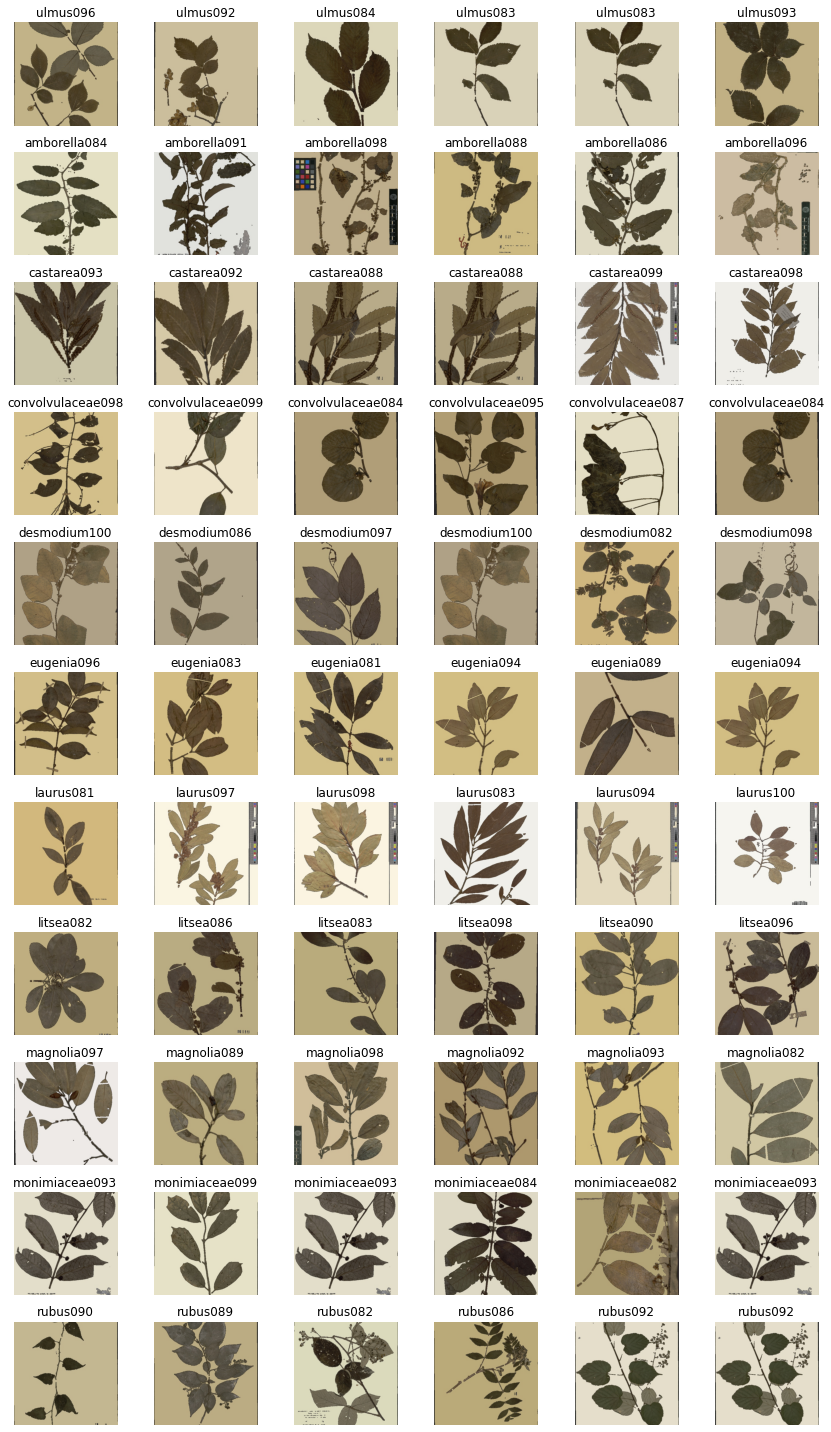

In [17]:
dictTrainDir = dict()
for specie in os.listdir(trainPath):
    dictTrainDir.update({specie: (trainPath / specie)})
    
lsPathsImage = []

numbSample = 6 # We set the number of images we want to show per category

# Loop through each category
for curKey in dictTrainDir:
    lsFiles = random.choices(os.listdir(dictTrainDir[curKey]), k=numbSample)
    lsPaths = list(map(lambda fileName : os.path.join(dictTrainDir[curKey], fileName), lsFiles))
    lsPathsImage.append(lsPaths)


# Set the Figures and Axes
fig, axes = plt.subplots(nrows=len(lsPathsImage), ncols=numbSample, figsize=(12,20))
fig.set_facecolor('white')

# Original
for row in range(len(lsPathsImage)):
    for col in range(numbSample):
        imagePath = lsPathsImage[row-1][col-1]
        imageTitle = imagePath.replace('\\', '/').split('/')[-1].split('.')[0]
        curImage = cv2.imread(imagePath)
        
        axes[(row, col)].imshow(np.array(cv2.cvtColor(curImage, cv2.COLOR_BGR2RGB)))
        axes[(row, col)].set_title(imageTitle) 
        axes[(row, col)].axis('off')

# Thight the Layout
plt.tight_layout()

# Display the Figure
plt.show()

##### Build the Dataframe with the Species and their corresponding Attribute 

In [18]:
# Définir les Informations connu d'après les 4 caractères descriptifs des 11 taxons
# Devrions-nous faire une transformation binaire?
# Bord : { Lisse = 0 / Denté = 1 }
# Phyllotaxie : { Opposé = 0 / Alterné = 1 }
# Type Feuille : { Simple = 0 / Composée = 1 }
# Ligneux : { Non = 0 / Oui = 1 }

def makeBinaryHerbarium(lsHerbarium):
    lsHerbarium[0] = 0 if (lsHerbarium[0]=='lisse') else 1
    lsHerbarium[1] = 0 if (lsHerbarium[1]=='opposé') else 1
    lsHerbarium[2] = 0 if (lsHerbarium[2]=='simple') else 1
    lsHerbarium[3] = 0 if (lsHerbarium[3]=='non') else 1
    return lsHerbarium

Herbarium = dict({
    'amborella': ['lisse', 'alterné', 'simple', 'oui'],
    'castanea': ['denté', 'alterné', 'simple', 'oui'],
    'desmodium': ['lisse', 'alterné', 'composée', 'non'],
    'eugenia': ['lisse', 'opposé', 'simple', 'oui'],
    'laurus': ['lisse', 'opposé', 'simple', 'oui'],
    'litsea': ['lisse', 'alterné', 'simple', 'oui'],
    'magnolia': ['lisse', 'alterné', 'simple', 'oui'],
    'rubus': ['denté', 'alterné', 'composée', 'oui'],
    'ulmus': ['denté', 'alterné', 'simple', 'oui'],
    'monimiaceae': ['lisse', 'opposé', 'simple', 'oui'],
    'convolvulaceae': ['lisse', 'alterné', 'simple', 'non']
})

binaryHerbarium = {herb: makeBinaryHerbarium(Herbarium[herb].copy()) for herb in Herbarium.keys()}

In [21]:
def getFilesPath(dirPath):
    lsPathFiles = []
    for dir_, _, files in os.walk(dirPath):
        for file_name in files:
            lsPathFiles.append(re.search(rf'{dirPath.name}.*', (initDatasetPath / dir_ / file_name).__str__()).group())
    return lsPathFiles

def makeDataFrames(dirPath, savePath, pcrtValidation=0.7):
    lsPathImages, lsHerbarium = getFilesPath(dirPath), [] 
    
    # Append Information about the Images and the attributes to the corresponding Species
    for pathImage in lsPathImages:  # Loop through each Images
        typeImage = pathImage.replace('\\', '/').split('/')[-3]
        shapeImage = cv2.imread(((dirPath.parent / pathImage).__str__())).shape
        sizeImage = np.product(shapeImage)
        nameHerbarium = pathImage.replace('\\', '/').split('/')[-2]  
        lsHerbarium.append([pathImage, typeImage, shapeImage, sizeImage, nameHerbarium] + Herbarium[nameHerbarium] + binaryHerbarium[nameHerbarium])
    
    # Build the Dataframe and divide it as Test and Train   
    dfImageHerbarium = pd.DataFrame (lsHerbarium, columns = ['ImagePath', 'Type', 'ImageShape', 'ImageSize', 'Herbarium', 'Bord', 'Phyllotaxie', 'TypeFeuille', 'Ligneux', 'binaryBord', 'binaryPhyllotaxie', 'binaryTypeFeuille', 'binaryLigneux'])
    dfImageHerbariumTest = dfImageHerbarium[dfImageHerbarium['Type'] == 'Test']
    dfImageHerbariumValidation = pd.DataFrame()
    
    # print(dfImageHerbarium[(dfImageHerbarium['Type']=='Test') & (dfImageHerbarium['Herbarium']=='rubus')])
    for herbarium in np.unique(dfImageHerbariumTest['Herbarium']):
        dfImageHerbariumValidation = pd.concat([dfImageHerbariumValidation , dfImageHerbarium[(dfImageHerbarium['Type']=='Test') & (dfImageHerbarium['Herbarium']==herbarium)].sample(frac=pcrtValidation)])
    dfImageHerbariumValidation['Type'] = 'Validation'
    dfImageHerbariumTest = dfImageHerbarium[dfImageHerbarium['Type'] == 'Test'].drop(dfImageHerbariumValidation.index)
    dfImageHerbariumTrain = dfImageHerbarium[dfImageHerbarium['Type'] == 'Train']
    
    # Split and Save into two SubDatasets (Test and Train)
    filenameTrain, filenameTest, filenameValidation = 'transformedTrainDataset.csv', 'transformedTestDataset.csv', 'transformedValidationDataset.csv'
    dfImageHerbariumTrain.to_csv(path_or_buf=(savePath / filenameTrain), index = 0)
    dfImageHerbariumTest.to_csv(path_or_buf=(savePath / filenameTest), index = 0)
    dfImageHerbariumValidation.to_csv(path_or_buf=(savePath / filenameValidation), index = 0)
   
    print('Dataframe Succesfully Created')
    print(f'Train Dataframe Path -> {re.search(rf"{savePath.name}.*", (savePath / filenameTrain).__str__()).group()} ')
    print(f'Test Dataframe Path -> {re.search(rf"{savePath.name}.*", (savePath / filenameTest).__str__()).group()} ')
    print(f'Validation Dataframe Path -> {re.search(rf"{savePath.name}.*", (savePath / filenameValidation).__str__()).group()} ')

---

In [22]:
# makeDataFrames(initDatasetPath, dataPath, pcrtValidation=0) # Undo this comment if you want to build the Initial Daframes

makeDataFrames(modifDatasetPath, dataPath, pcrtValidation=0.75)

Dataframe Succesfully Created
Train Dataframe Path -> Data\transformedTrainDataset.csv 
Test Dataframe Path -> Data\transformedTestDataset.csv 
Validation Dataframe Path -> Data\transformedValidationDataset.csv 


#### Deep Learning Models

##### Classification for the Species Attributes 

In this **Section**, we want to realize a object recognition from different vegetal species. The purpose is to use the *Train* and *Test* data to build a model that allow the object recognition and in our case the detection of vegetal attributes.

An attribute represents a descriptive character of vegetal. For instance an attribute of the *magnolia* can be the arrangement of its leaves that are alternate. 

##### Step 1: Load the Transformed **Dataframe** of **Train** and **Test**

In [27]:
trainFilename, validationFilename, testFilename = 'transformedTrainDataset.csv',  'transformedValidationDataset.csv', 'transformedTestDataset.csv'

if trainFilename in os.listdir(dataPath):
    dfTrain = pd.read_csv(filepath_or_buffer=(dataPath / trainFilename))
    print('Train Dataframe -> Successfully Loaded')
else:
    print('Train Dataframe -> Unsuccessfully Loaded | Modify the Path or Reexecute the current Notebook')
    
    
if validationFilename in os.listdir(dataPath):
    dfValidation = pd.read_csv(filepath_or_buffer=(dataPath / validationFilename))
    print('Validation Dataframe -> Successfully Loaded')
else:
    print('Validation Dataframe -> Unsuccessfully Loaded | Modify the Path or Reexecute the current Notebook')
    
    
if testFilename in os.listdir(dataPath):
    dfTest = pd.read_csv(filepath_or_buffer=(dataPath / testFilename))
    print('Test Dataframe -> Successfully Loaded')
else:
    print('Test Dataframe -> Unsuccessfully Loaded | Modify the Path or Reexecute the current Notebook')    

Train Dataframe -> Successfully Loaded
Validation Dataframe -> Successfully Loaded
Test Dataframe -> Successfully Loaded


##### Step 2: Construct the Generator for each Attribute

In [28]:
def constructGeneratorfromDataframe(generator, df, colsFeature, targetSize, batchSize):
    return generator.flow_from_dataframe(df, x_col=colsFeature[0], y_col=colsFeature[1], target_size=targetSize, batch_size=batchSize, class_mode="sparse")

In [32]:
# All images will be rescaled by 1./255
trainGenerator = ImageDataGenerator(rescale=1./255)
validationGenerator = ImageDataGenerator(rescale=1./255)
testGenerator = ImageDataGenerator(rescale=1./255)

inputShape = cv2.imread((modifDatasetPath / 'Test' / 'amborella'  / 'amborella071.jpg').__str__()).shape
target_size = (512, 512)    
batch_size = 32
print('Input Shape:', inputShape)
print('Target Size:', target_size)
print('Bach Size:', batch_size)

dfTrain['ImageAbsolutePath'] = (dataPath / dfTrain['ImagePath']) # Get Absolute Path
dfTrain['ImageAbsolutePath'] = dfTrain['ImageAbsolutePath'].astype(str).replace('\\', '/')  # Get Absolute Path

dfValidation['ImageAbsolutePath'] = (dataPath / dfValidation['ImagePath']) # Get Absolute Path
dfValidation['ImageAbsolutePath'] = dfValidation['ImageAbsolutePath'].astype(str).replace('\\', '/')  # Get Absolute Path

dfTest['ImageAbsolutePath'] = (dataPath / dfTest['ImagePath']) # Get Absolute Path
dfTest['ImageAbsolutePath'] = dfTest['ImageAbsolutePath'].astype(str).replace('\\', '/')  # Get Absolute Path


print('\nTrain Generator:')
trainGeneratorBord = constructGeneratorfromDataframe(trainGenerator, dfTrain, ['ImageAbsolutePath', 'Bord'], target_size, batch_size)
trainGeneratorPhyllotaxie = constructGeneratorfromDataframe(trainGenerator, dfTrain, ['ImageAbsolutePath', 'Phyllotaxie'], target_size, batch_size)
trainGeneratorTypeFeuille = constructGeneratorfromDataframe(trainGenerator, dfTrain, ['ImageAbsolutePath', 'TypeFeuille'], target_size, batch_size)
trainGeneratorLigneux = constructGeneratorfromDataframe(trainGenerator, dfTrain, ['ImageAbsolutePath', 'Ligneux'], target_size, batch_size)
trainGeneratorHerbarium = constructGeneratorfromDataframe(trainGenerator, dfTrain, ['ImageAbsolutePath', 'Herbarium'], target_size, batch_size)

print('\nValidation Generator:')
validationGeneratorBord = constructGeneratorfromDataframe(validationGenerator, dfValidation, ['ImageAbsolutePath', 'Bord'], target_size, batch_size)
validationGeneratorPhyllotaxie = constructGeneratorfromDataframe(validationGenerator, dfValidation, ['ImageAbsolutePath', 'Phyllotaxie'], target_size, batch_size)
validationGeneratorTypeFeuille = constructGeneratorfromDataframe(validationGenerator, dfValidation, ['ImageAbsolutePath', 'TypeFeuille'], target_size, batch_size)
validationGeneratorLigneux = constructGeneratorfromDataframe(validationGenerator, dfValidation, ['ImageAbsolutePath', 'Ligneux'], target_size, batch_size)
validationGeneratorHerbarium = constructGeneratorfromDataframe(validationGenerator, dfValidation, ['ImageAbsolutePath', 'Herbarium'], target_size, batch_size)

print('\nTest Generator:')
testGeneratorBord = constructGeneratorfromDataframe(testGenerator, dfTest, ['ImageAbsolutePath', 'Bord'], target_size, batch_size)
testGeneratorPhyllotaxie = constructGeneratorfromDataframe(testGenerator, dfTest, ['ImageAbsolutePath', 'Phyllotaxie'], target_size, batch_size)
testGeneratorTypeFeuille = constructGeneratorfromDataframe(testGenerator, dfTest, ['ImageAbsolutePath', 'TypeFeuille'], target_size, batch_size)
testGeneratorLigneux = constructGeneratorfromDataframe(testGenerator, dfTest, ['ImageAbsolutePath', 'Ligneux'], target_size, batch_size)
testGeneratorHerbarium = constructGeneratorfromDataframe(testGenerator, dfTest, ['ImageAbsolutePath', 'Herbarium'], target_size, batch_size)


Input Shape: (512, 512, 3)
Target Size: (512, 512)
Bach Size: 32

Train Generator:
Found 220 validated image filenames belonging to 2 classes.
Found 220 validated image filenames belonging to 2 classes.
Found 220 validated image filenames belonging to 2 classes.
Found 220 validated image filenames belonging to 2 classes.
Found 220 validated image filenames belonging to 11 classes.

Validation Generator:
Found 88 validated image filenames belonging to 2 classes.
Found 88 validated image filenames belonging to 2 classes.
Found 88 validated image filenames belonging to 2 classes.
Found 88 validated image filenames belonging to 2 classes.
Found 88 validated image filenames belonging to 11 classes.

Test Generator:
Found 22 validated image filenames belonging to 2 classes.
Found 22 validated image filenames belonging to 2 classes.
Found 22 validated image filenames belonging to 2 classes.
Found 22 validated image filenames belonging to 2 classes.
Found 22 validated image filenames belonging

##### Step 3: Construct the Model

In [33]:
def makeModel_ClassificationAttributes(dataAugmentation, inputShape, outputSize, outputActivationFunction, choiceOptimizer, choiceLoss, choiceMetrics):
    model = models.Sequential()
    if dataAugmentation:
        model = models.Sequential([layers.Input(inputShape), dataAugmentation])
    model.add(layers.Conv2D(32, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(512, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(outputSize, activation = outputActivationFunction))  # Tester Softmax
    model.compile(optimizer=choiceOptimizer, loss=choiceLoss, metrics=choiceMetrics)
    return model



In [34]:
dataAugmentation = tf.keras.Sequential([layers.RandomFlip("horizontal"), layers.RandomRotation(0.2)])
outputActivationFunction = 'sigmoid'
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = 'sparse_categorical_crossentropy'
metrics = ['accuracy']

print('Output Activation Function:', outputActivationFunction)
print('Optimize:', optimizer)
print('Loss:', loss)
print('Metrics:', metrics)

Output Activation Function: sigmoid
Optimize: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7ff90a55d640>
Loss: sparse_categorical_crossentropy
Metrics: ['accuracy']


In [35]:
modelBord = makeModel_ClassificationAttributes(dataAugmentation, (512, 512, 3), len(trainGeneratorBord.class_indices), outputActivationFunction, optimizer, loss, metrics)
modelBord.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)    

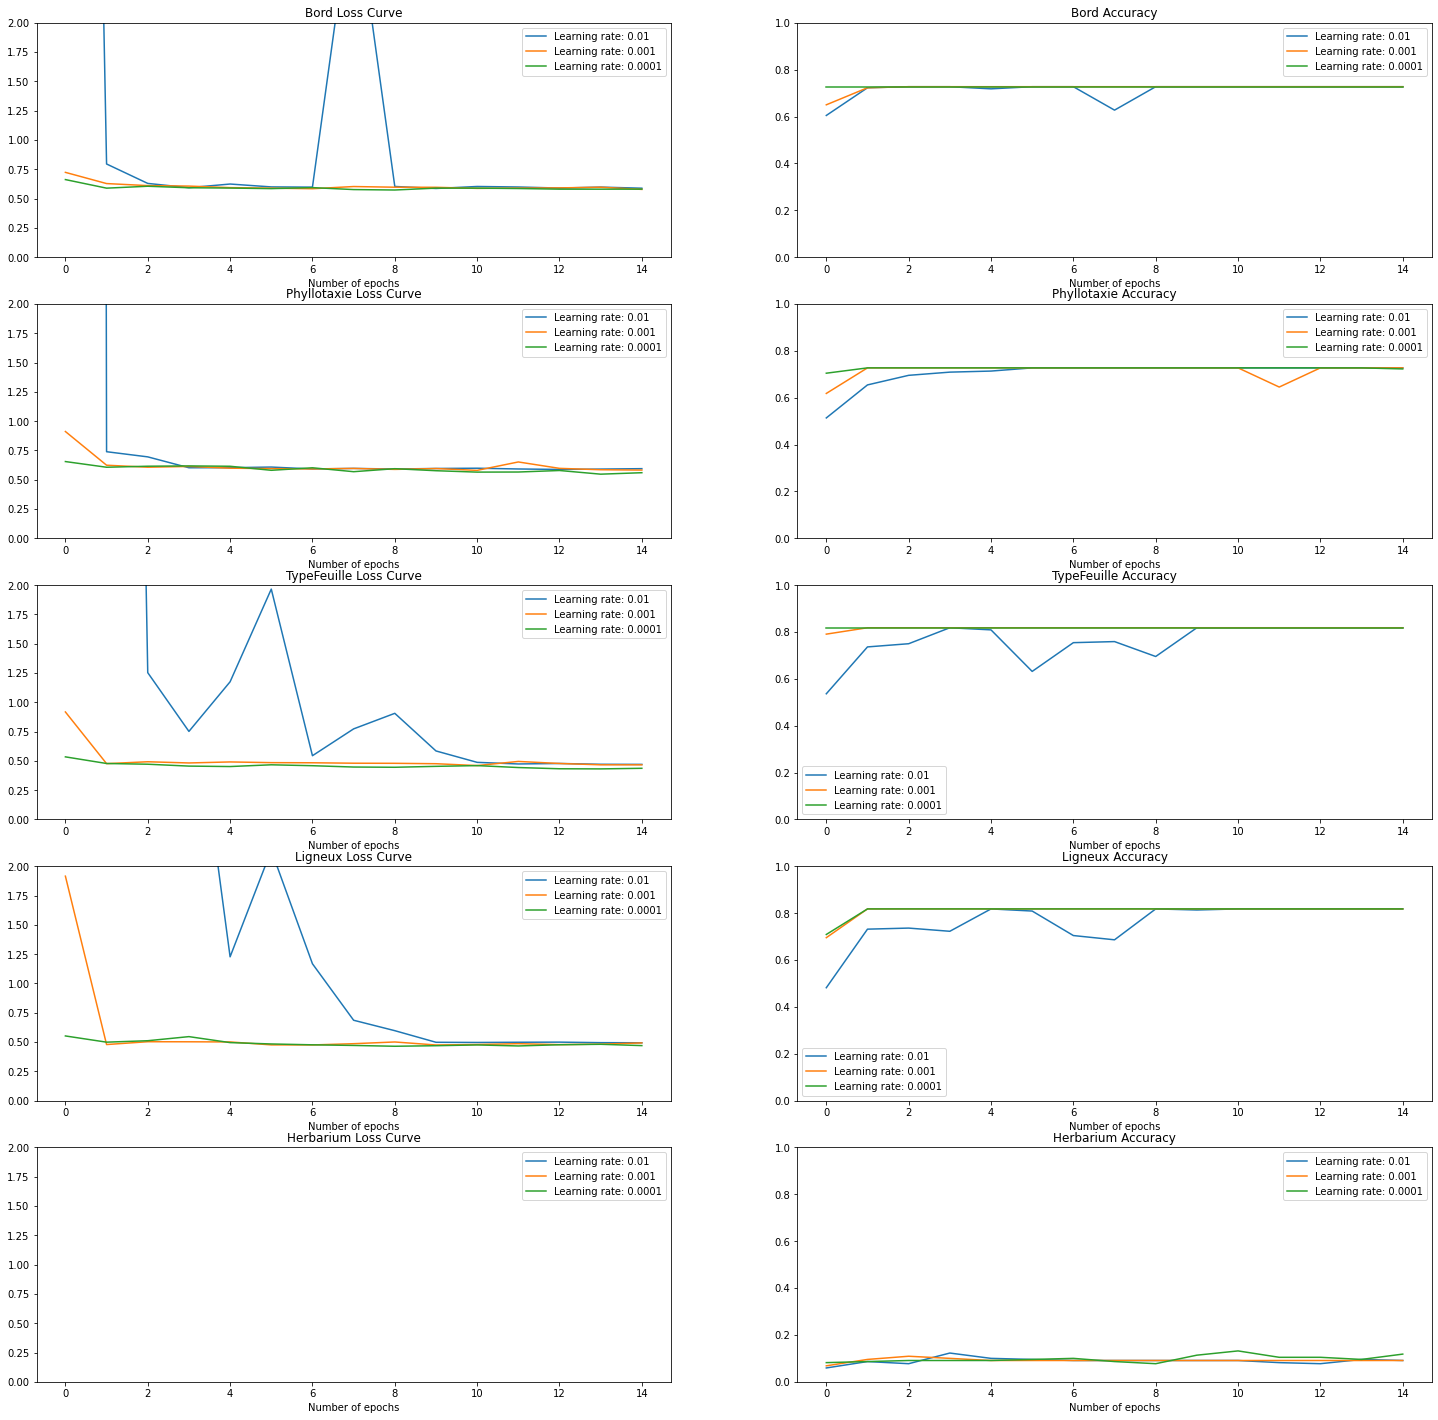

In [37]:
# Set the learning rates to use
learning_rates = [0.01, 0.001, 0.0001]

# Set the number of epochs
num_epochs = 15

# Create a new figure with multiple subplots
row, col = 5,2
fig, axs = plt.subplots(row, col, figsize=(25,25))

# Shapes
inputShape = (512, 512, 3)
outputSizeFeatures = len(trainGeneratorBord.class_indices)
outputSizeHerbarium = len(trainGeneratorHerbarium.class_indices)

# Iterate over the learning rates
for i, lr in enumerate(learning_rates):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    # Train the model with the current learning rate
    modelBord = makeModel_ClassificationAttributes(dataAugmentation, inputShape, outputSizeFeatures, outputActivationFunction, optimizer, loss, metrics)
    modelPhyllotaxie = makeModel_ClassificationAttributes(dataAugmentation, inputShape, outputSizeFeatures, outputActivationFunction, optimizer, loss, metrics)
    modelTypeFeuille = makeModel_ClassificationAttributes(dataAugmentation, inputShape, outputSizeFeatures, outputActivationFunction, optimizer, loss, metrics)
    modelLigneux = makeModel_ClassificationAttributes(dataAugmentation, inputShape, outputSizeFeatures, outputActivationFunction, optimizer, loss, metrics)
    modelHerbarium = makeModel_ClassificationAttributes(dataAugmentation, inputShape, outputSizeHerbarium, outputActivationFunction, optimizer, loss, metrics)

    historyBord = modelBord.fit(trainGeneratorBord, epochs=num_epochs, validation_data=validationGeneratorBord, verbose = 0)
    historyPhyllotaxie = modelPhyllotaxie.fit(trainGeneratorPhyllotaxie, epochs=num_epochs, validation_data=validationGeneratorPhyllotaxie, verbose = 0)
    historyTypeFeuille = modelTypeFeuille.fit(trainGeneratorTypeFeuille, epochs=num_epochs, validation_data=validationGeneratorTypeFeuille, verbose = 0)
    historyLigneux = modelLigneux.fit(trainGeneratorLigneux, epochs=num_epochs, validation_data=validationGeneratorLigneux, verbose = 0)
    historyHerbarium = modelHerbarium.fit(trainGeneratorHerbarium, epochs=num_epochs, validation_data=validationGeneratorHerbarium, verbose = 0)

    # Plot the loss curve for the current learning rate
    axs[0, 0].plot(historyBord.history['loss'], label='Learning rate: {}'.format(lr))
    axs[0, 0].set_title('Bord Loss Curve')
    axs[0, 0].set_ylim(0,2)
    axs[0, 1].plot(historyBord.history['accuracy'], label='Learning rate: {}'.format(lr))
    axs[0, 1].set_title('Bord Accuracy')
    axs[0, 1].set_ylim(0,1)

    axs[1, 0].plot(historyPhyllotaxie.history['loss'], label='Learning rate: {}'.format(lr))
    axs[1, 0].set_title('Phyllotaxie Loss Curve')
    axs[1, 0].set_ylim(0,2)
    axs[1, 1].plot(historyPhyllotaxie.history['accuracy'], label='Learning rate: {}'.format(lr))
    axs[1, 1].set_title('Phyllotaxie Accuracy')
    axs[1, 1].set_ylim(0,1)

    axs[2, 0].plot(historyTypeFeuille.history['loss'], label='Learning rate: {}'.format(lr))
    axs[2, 0].set_title('TypeFeuille Loss Curve')
    axs[2, 0].set_ylim(0,2)
    axs[2, 1].plot(historyTypeFeuille.history['accuracy'], label='Learning rate: {}'.format(lr))
    axs[2, 1].set_title('TypeFeuille Accuracy')
    axs[2, 1].set_ylim(0,1)

    axs[3, 0].plot(historyLigneux.history['loss'], label='Learning rate: {}'.format(lr))
    axs[3, 0].set_title('Ligneux Loss Curve')
    axs[3, 0].set_ylim(0,2)
    axs[3, 1].plot(historyLigneux.history['accuracy'], label='Learning rate: {}'.format(lr))
    axs[3, 1].set_title('Ligneux Accuracy')
    axs[3, 1].set_ylim(0,1)

    axs[4, 0].plot(historyHerbarium.history['loss'], label='Learning rate: {}'.format(lr))
    axs[4, 0].set_title('Herbarium Loss Curve')
    axs[4, 0].set_ylim(0,2)
    axs[4, 1].plot(historyHerbarium.history['accuracy'], label='Learning rate: {}'.format(lr))
    axs[4, 1].set_title('Herbarium Accuracy')
    axs[4, 1].set_ylim(0,1)

    for ax in axs.ravel():
      ax.set_xlabel('Number of epochs')
      ax.legend()

    for ax in axs.ravel():
      ax.set_xlabel('Number of epochs')
      ax.legend()

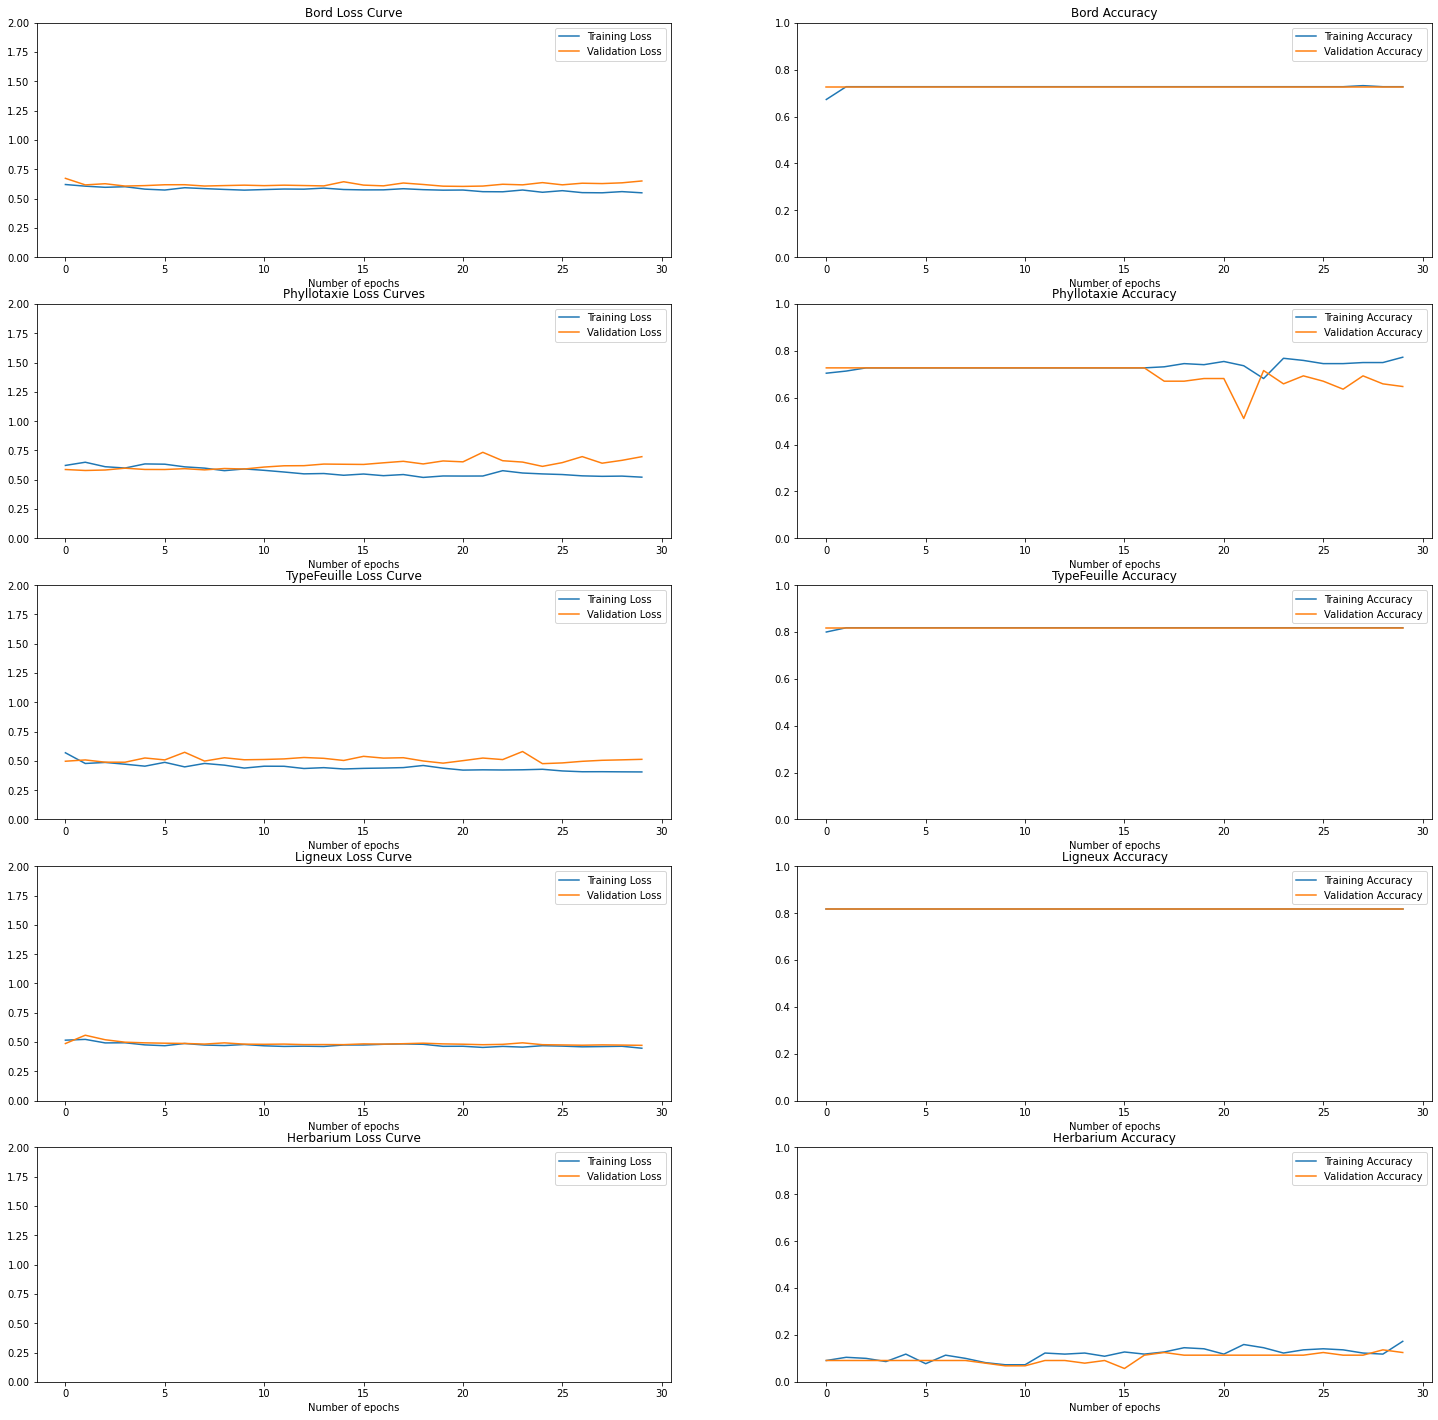

In [38]:
# Set the learning rates to use
lr = 0.0001

# Set the number of epochs
num_epochs = 30

# Create a new figure with multiple subplots
row, col = 5,2
fig, axs = plt.subplots(row, col, figsize=(25,25))

# Shapes
inputShape = (512, 512, 3)
outputSizeFeatures = len(trainGeneratorBord.class_indices)
outputSizeHerbarium = len(trainGeneratorHerbarium.class_indices)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# Train the model with the current learning rate
modelBord = makeModel_ClassificationAttributes(dataAugmentation, inputShape, outputSizeFeatures, outputActivationFunction, optimizer, loss, metrics)
modelPhyllotaxie = makeModel_ClassificationAttributes(dataAugmentation, inputShape, outputSizeFeatures, outputActivationFunction, optimizer, loss, metrics)
modelTypeFeuille = makeModel_ClassificationAttributes(dataAugmentation, inputShape, outputSizeFeatures, outputActivationFunction, optimizer, loss, metrics)
modelLigneux = makeModel_ClassificationAttributes(dataAugmentation, inputShape, outputSizeFeatures, outputActivationFunction, optimizer, loss, metrics)
modelHerbarium = makeModel_ClassificationAttributes(dataAugmentation, inputShape, outputSizeHerbarium, outputActivationFunction, optimizer, loss, metrics)

historyBord = modelBord.fit(trainGeneratorBord, epochs=num_epochs, validation_data=validationGeneratorBord, verbose = 0)
historyPhyllotaxie = modelPhyllotaxie.fit(trainGeneratorPhyllotaxie, epochs=num_epochs, validation_data=validationGeneratorPhyllotaxie, verbose = 0)
historyTypeFeuille = modelTypeFeuille.fit(trainGeneratorTypeFeuille, epochs=num_epochs, validation_data=validationGeneratorTypeFeuille, verbose = 0)
historyLigneux = modelLigneux.fit(trainGeneratorLigneux, epochs=num_epochs, validation_data=validationGeneratorLigneux, verbose = 0)
historyHerbarium = modelHerbarium.fit(trainGeneratorHerbarium, epochs=num_epochs, validation_data=validationGeneratorHerbarium, verbose = 0)

# Plot the loss curve for the current learning rate
axs[0, 0].plot(historyBord.history['loss'], label='Training Loss')
axs[0, 0].plot(historyBord.history['val_loss'], label='Validation Loss')
axs[0, 0].set_title('Bord Loss Curve')
axs[0, 0].set_ylim(0,2)
axs[0, 1].plot(historyBord.history['accuracy'], label='Training Accuracy')
axs[0, 1].plot(historyBord.history['val_accuracy'], label='Validation Accuracy')
axs[0, 1].set_title('Bord Accuracy')
axs[0, 1].set_ylim(0,1)

axs[1, 0].plot(historyPhyllotaxie.history['loss'], label='Training Loss')
axs[1, 0].plot(historyPhyllotaxie.history['val_loss'], label='Validation Loss')
axs[1, 0].set_title('Phyllotaxie Loss Curves')
axs[1, 0].set_ylim(0,2)
axs[1, 1].plot(historyPhyllotaxie.history['accuracy'], label='Training Accuracy')
axs[1, 1].plot(historyPhyllotaxie.history['val_accuracy'], label='Validation Accuracy')
axs[1, 1].set_title('Phyllotaxie Accuracy')
axs[1, 1].set_ylim(0,1)

axs[2, 0].plot(historyTypeFeuille.history['loss'], label='Training Loss')
axs[2, 0].plot(historyTypeFeuille.history['val_loss'], label='Validation Loss')
axs[2, 0].set_title('TypeFeuille Loss Curve')
axs[2, 0].set_ylim(0,2)
axs[2, 1].plot(historyTypeFeuille.history['accuracy'], label='Training Accuracy')
axs[2, 1].plot(historyTypeFeuille.history['val_accuracy'], label='Validation Accuracy')
axs[2, 1].set_title('TypeFeuille Accuracy')
axs[2, 1].set_ylim(0,1)

axs[3, 0].plot(historyLigneux.history['loss'], label='Training Loss')
axs[3, 0].plot(historyLigneux.history['val_loss'], label='Validation Loss')
axs[3, 0].set_title('Ligneux Loss Curve')
axs[3, 0].set_ylim(0,2)
axs[3, 1].plot(historyLigneux.history['accuracy'], label='Training Accuracy')
axs[3, 1].plot(historyLigneux.history['val_accuracy'], label='Validation Accuracy')
axs[3, 1].set_title('Ligneux Accuracy')
axs[3, 1].set_ylim(0,1)

axs[4, 0].plot(historyHerbarium.history['loss'], label='Training Loss')
axs[4, 0].plot(historyHerbarium.history['val_loss'], label='Validation Loss')
axs[4, 0].set_title('Herbarium Loss Curve')
axs[4, 0].set_ylim(0,2)
axs[4, 1].plot(historyHerbarium.history['accuracy'], label='Training Accuracy')
axs[4, 1].plot(historyHerbarium.history['val_accuracy'], label='Validation Accuracy')
axs[4, 1].set_title('Herbarium Accuracy')
axs[4, 1].set_ylim(0,1)

for ax in axs.ravel():
  ax.set_xlabel('Number of epochs')
  ax.legend()


##### Evaluate the Model

In [39]:
modelBord.evaluate(testGeneratorBord)
modelPhyllotaxie.evaluate(testGeneratorPhyllotaxie)
modelTypeFeuille.evaluate(testGeneratorTypeFeuille)
modelLigneux.evaluate(testGeneratorLigneux)
modelHerbarium.evaluate(testGeneratorHerbarium)

1/1 [==============================] - 0s 279ms/step - loss: 2.3600 - accuracy: 0.1364


[2.35996150970459, 0.13636364042758942]

In [40]:
predBord = modelBord.predict(testGeneratorBord)
predPhyllotaxie = modelPhyllotaxie.predict(testGeneratorPhyllotaxie)
predTypeFeuille = modelTypeFeuille.predict(testGeneratorTypeFeuille)
predLigneux = modelLigneux.predict(testGeneratorLigneux)
predHerbarium = modelHerbarium.predict(testGeneratorHerbarium)

1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 282ms/step


In [41]:
predClassBord = np.argmax(predBord, axis=1)
predClassPhyllotaxie = np.argmax(predPhyllotaxie, axis=1)
predClassTypeFeuille = np.argmax(predTypeFeuille, axis=1)
predClassLigneux = np.argmax(predLigneux, axis=1)
predClassHerbarium = np.argmax(predHerbarium, axis=1)

In [42]:
testBordLabels = testGeneratorBord[0][1]
testPhyllotaxieLabels = testGeneratorPhyllotaxie[0][1]
testTypeFeuilleLabels = testGeneratorTypeFeuille[0][1]
testLigneuxLabels = testGeneratorLigneux[0][1]
testHerbariumLabels = testGeneratorHerbarium[0][1]

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy score for', 
  'Bord:',"%.2f" % accuracy_score(predClassBord, testBordLabels),
  'Phyllotaxie:',"%.2f" % accuracy_score(predClassPhyllotaxie, testPhyllotaxieLabels),
  'TypeFeuille:',"%.2f" % accuracy_score(predClassTypeFeuille, testTypeFeuilleLabels),
  'Ligneux:',"%.2f" % accuracy_score(predClassLigneux, testLigneuxLabels),
  'Herbarium:',"%.2f" % accuracy_score(predClassHerbarium, testHerbariumLabels)
)
print('Precision score for', 
  'Bord:',"%.2f" % precision_score(predClassBord, testBordLabels),
  'Phyllotaxie:',"%.2f" % precision_score(predClassPhyllotaxie, testPhyllotaxieLabels),
  'TypeFeuille:',"%.2f" % precision_score(predClassTypeFeuille, testTypeFeuilleLabels),
  'Ligneux:',"%.2f" % precision_score(predClassLigneux, testLigneuxLabels),
  'Herbarium:',"%.2f" % precision_score(predClassHerbarium, testHerbariumLabels, average = 'macro')
)
print('Recall score for', 
  'Bord:',"%.2f" % recall_score(predClassBord, testBordLabels),
  'Phyllotaxie:',"%.2f" % recall_score(predClassPhyllotaxie, testPhyllotaxieLabels),
  'TypeFeuille:',"%.2f" % recall_score(predClassTypeFeuille, testTypeFeuilleLabels),
  'Ligneux:',"%.2f" % recall_score(predClassLigneux, testLigneuxLabels),
  'Herbarium:',"%.2f" % recall_score(predClassHerbarium, testHerbariumLabels, average = 'macro', zero_division = 0)
)
print('F1 score for', 
  'Bord:',"%.2f" % f1_score(predClassBord, testBordLabels),
  'Phyllotaxie:',"%.2f" % f1_score(predClassPhyllotaxie, testPhyllotaxieLabels),
  'TypeFeuille:',"%.2f" % f1_score(predClassTypeFeuille, testTypeFeuilleLabels),
  'Ligneux:',"%.2f" % f1_score(predClassLigneux, testLigneuxLabels),
  'Herbarium:',"%.2f" % f1_score(predClassHerbarium, testHerbariumLabels, average = 'macro')
)

Accuracy score for Bord: 0.73 Phyllotaxie: 0.68 TypeFeuille: 0.82 Ligneux: 0.82 Herbarium: 0.09
Precision score for Bord: 1.00 Phyllotaxie: 0.00 TypeFeuille: 1.00 Ligneux: 1.00 Herbarium: 0.09
Recall score for Bord: 0.73 Phyllotaxie: 0.00 TypeFeuille: 0.82 Ligneux: 0.82 Herbarium: 0.01
F1 score for Bord: 0.84 Phyllotaxie: 0.00 TypeFeuille: 0.90 Ligneux: 0.90 Herbarium: 0.02


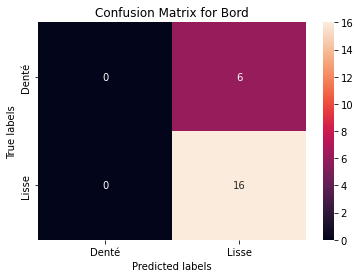

In [44]:
ax= plt.subplot()
cf_matrix = confusion_matrix(testBordLabels, predClassBord)
sns.heatmap(cf_matrix, annot=True)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Bord');
ax.xaxis.set_ticklabels(['Denté', 'Lisse']); ax.yaxis.set_ticklabels(['Denté', 'Lisse']);

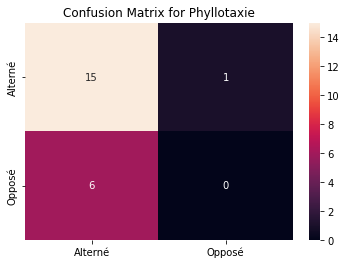

In [45]:
ax= plt.subplot()
cf_matrix = confusion_matrix(testPhyllotaxieLabels, predClassPhyllotaxie)
sns.heatmap(cf_matrix, annot=True)
ax.set_title('Confusion Matrix for Phyllotaxie');
ax.xaxis.set_ticklabels(['Alterné', 'Opposé']); ax.yaxis.set_ticklabels(['Alterné', 'Opposé']);

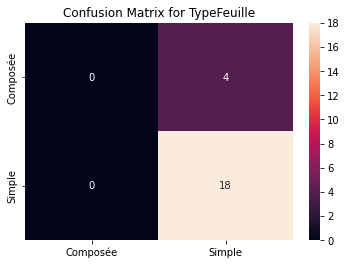

In [46]:
ax= plt.subplot()
cf_matrix = confusion_matrix(testTypeFeuilleLabels, predClassTypeFeuille)
sns.heatmap(cf_matrix, annot=True)
ax.set_title('Confusion Matrix for TypeFeuille');
ax.xaxis.set_ticklabels(['Composée', 'Simple']); ax.yaxis.set_ticklabels(['Composée', 'Simple']);

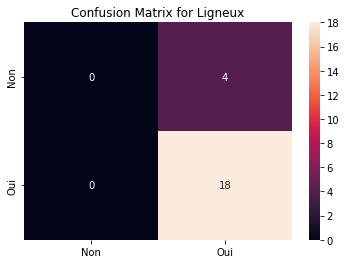

In [47]:
ax= plt.subplot()
cf_matrix = confusion_matrix(testLigneuxLabels, predClassLigneux)
sns.heatmap(cf_matrix, annot=True)
ax.set_title('Confusion Matrix for Ligneux');
ax.xaxis.set_ticklabels(['Non', 'Oui']); ax.yaxis.set_ticklabels(['Non', 'Oui']);

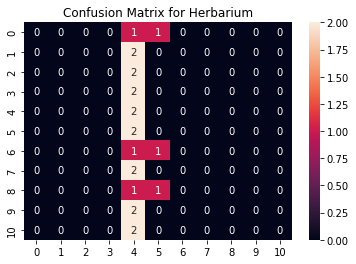

In [48]:
ax= plt.subplot()
cf_matrix = confusion_matrix(testHerbariumLabels, predClassHerbarium)
sns.heatmap(cf_matrix, annot=True)
ax.set_title('Confusion Matrix for Herbarium');